# Stability analysis

## what we have:
the purpose of this notebook is to analyse individual patients' timelines with respect to their "attraction" to one or more of the clusters generated by LDA (see notebook NB1: LDA_topics_generator...")

to achieve this, it assumes that "per-stage association vectors" for each patient have been previously generated -- this happens in NB1.

Here is an example of sequence of stages, for a patient with timeline: `['OA', 'skin_ulcer', 'dermatitis']`:

`[ [PMR], [PMR, glaucoma]], 1000059: [['OA'], ['OA', 'skin_ulcer'], ['OA', 'skin_ulcer', 'dermatitis']]`

the code below:
- calculates the **trajectory** for each patient. This is defined as the sequence of <R,theta> values (see below for an informal definition), one for each stage in the patient's timeline.
- based on the shape of the trajectory, it labels each patient as "stable", "unstable", but also allows a patient to be "stable after a certain point in time" (*eventually stable*) or "stable until a certain point in time". A stable or eventually stable patient will have a cluster asosciated with them, which is the last cluster pointed to by theta in the sequence, and is called the *dominant* cluster.
- generates a new dataframe where each patient and their trajectories are associated with a stability label, and the dominant cluster.

## What needs to be done next:
Starting from the new dataframe, we want to analyse the collection of patients and their trajectories to try and determine what characterises stable/unstable patients.
Ultimately, we want to determine (1) which patients can be reliably predicted to eventually fall into its dominant cluster, and (2) how soon the prediction can be made.

The following are some of the questions and tasks:
 - calculate the prevalence of each condition in (1) the general population, (2) the stable population, (3) the unstable population. How are they different? if visible differences exist, can these be quantified?
 - are some combinations or *sequences* of two or more conditions more likely to occur in one population than in another? (hopefully, it will be the case that 
 - for those patients that are "stable after X", how soon does X occur? in other words, how soon can we start predicting that someone falls into a specific cluster? to answer this, we may try several strategies. For example, we can look at the top-ranking diseases in each cluster (say, the top-10). We then look at timelines to see how early in the timeline these occur. For example, suppose disease D is top in cluster C, and D is the first event to occur for patient P. Intuitively, this can be taken as a strong signal that C will eventually be the dominant cluster for P, although this is not certain. In general, the sooner these top diseases are diagnoses occur in a patient, the more confident I can be in predicting their corresponding cluster will be the dominant cluster.

Once we have a strategy for making predictions regarding the dominant cluster, we need a way to validate them, in other words we need to quantify the *performance of the prediction*. This is actually trivial as we know the dominant cluster, so we can use that as ground truth to simply calculate the ture and false positives and negatives for each prediction.

This leads to a "parametric" performance metric, where parameter S indicates the stage at which we "take the guess". Obviously we expect performance to be low when S=1, unless the patient has exactly one of the top diseases right at the start, and to increase as we move towards the end of the timeline.

## changing the cluster structure
the setup just described should provide an interesting framework to experient with various predictive strategies based on partial information about patient timelines. but complete information about the clusters.

However, suppose we have more than one option to cluster the diseases in the first place. for instance, LDA allows (indeed it requires) to specify the number of clusters. Thus, the cluster themselves provide one more dimension for the analysis: everything that has been done above can be repeated for a different set of clusters, and this leads to a comparison acorss different clustering schemes. We could eventually use this analysis to suggest the optimal clustering scheme, which is the one that leads to the "best possible predictions" (in some sense to be defined precisely).

## defining trajectories: R and theta
the informal definition is simple as it is inspired by the physics of gravity. Assume you have 4 clusters, and imagine placing them on a circle, 90 degrees apart (so they are are 0, 90, 180, 270 deg). You are at the centre of the circle. You are "pulled" towards each cluster with a force that is represented by a weight found in a patient-association vector (calculated below). So given such a vector, you can compute the resultant of the forces. This is a vector with a strength (R) and a direction (theta, defined relative to the 0 degrees axis). 

We can generalise this to any number of clusters, for example 5 clusters will be placed at angles 0, 360/5, 360/5\*2, etc. and the same calculations will hold.

now, a patient is characterised by a sequence of such vectors, one per stage (see above). This means that we can calculate a sequence of <R,theta> values. Stability is defined by looking at changes in R, and the *dominant cluster* is the one in the direction theta (in some cases, theta actually points to an angle in between two clusters. This provides an uncertain dominant cluster).

In [1]:
import numpy as np
import math
import random
import pandas as pd

import os
from os import path

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Progress bar
from tqdm.notebook import tqdm

# Word Counter
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import pprint
pp = pprint.PrettyPrinter(indent=4)
import scipy.stats as ss
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import random
import statistics as st
from IPython.display import display


In [2]:
## local imports

# import sys
# sys.path.append('./content/drive/MyDrive')
# !pip install pyLDAvis
# # !cp CommonFunctions.py
# !python CommonFunctions.py
# from CommonFunctions import *

In [3]:
topics_count = 4
# Note: num_topics attempted: 20, 15, 10, 5, 6, ,7 , 8, 4

In [4]:
from  Constants import *
from  CommonFunctions import *

### load previously computed per-stage association vectors

exits if pickle file not found

In [5]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
TARGET_DIR = TOPICS_COUNTS_PATH + str(topics_count)

ALL_TRAJECTORIES_SUFF = TARGET_DIR +  "/"+ path.basename(ALL_TRAJECTORIES).split('.')[0]+ "_"+ str(topics_count)+"."+path.basename(ALL_TRAJECTORIES).split('.')[1]

print("looking for cached file in [{0}]".format(ALL_TRAJECTORIES_SUFF))
if path.exists(ALL_TRAJECTORIES_SUFF) and not FORCE_RECOMPUTE:
    with open(ALL_TRAJECTORIES_SUFF, 'rb') as f:
        trajectories =  pickle.load(f)
        patientCount = len(trajectories.keys())
        print('loaded trajectories [{0}] from cache with {1} patients'.format(ALL_TRAJECTORIES, patientCount))
else:
    print("cached file NOT found -- execute computeTrajectoryAssociations() again from [LDA_topics_generator_pipeline]")
    exit()


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


looking for cached file in [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/4/trajectories_4.pkl]
loaded trajectories [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/trajectories.pkl] from cache with 210210 patients


### load `stagesPerPatient` which contains the list of conditions --> full list is in the last stage!

In [23]:
if os.path.isfile(STAGES_PER_PATIENT) and not FORCE_RECOMPUTE:
    print("opening from {}".format(STAGES_PER_PATIENT))
    with open(STAGES_PER_PATIENT, 'rb') as f:
      stagesPerPatient =  pickle.load(f)
    print('loaded StagesPerPatients [{0}] from cache'.format(STAGES_PER_PATIENT))

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


opening from /Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/SPP.pkl
loaded StagesPerPatients [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/SPP.pkl] from cache


In [8]:
### example of calculating R and theta
R, theta = resultant([10,10,5])
# [10,5,5,2,2])

if theta == 0:
    print("R = {0:.2f}, theta = {1}\n".format(R, theta))
else:
    print("R = {0:.2f}, theta = {1:.2f}deg\n".format(R, theta))


R = 5.00, theta = 60.00 deg



/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## gravitational pull is summarised by calculating <R,theta>
## then, stability is defined by considering the sequence of R values

To determine stability, the code below looks at (1) the derivative: positive indicates increasing stability, and (2) the point where a trajectory with non-monotone derivative starts "definitely increasing", known as the elbow of the curve

In [12]:
# Find Elbow Point, Trade off Point the description of this code is provided below 
import numpy.matlib as npm

def elbow_point(data,gradient_r_values,Orig_list_vec):
    curve = data
    plt.plot(curve,label='Resultant stages')
    plt.plot(gradient_r_values,label='Gradients')
    plt.plot(Orig_list_vec, color='green')
    plt.ylabel("Gravidation pull values")
    plt.xlabel(" Events ")
    plt.ylim(-1, 5)
    
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    plt.axvline(x=idxOfBestPoint, color='r', linestyle='-')
    plt.legend()

    plt.show()
    return idxOfBestPoint

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


for each point p on the curve, we find the one with the maximum distance d given by the above figure


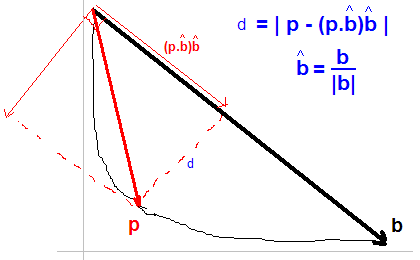

###### get coordinates of all the points
###### pull out first point
###### get vector between first and last point - this is the line
###### normalize the line vector
###### find the distance from each point to the line:
###### vector between all points and first point
###### To calculate the distance to the line, we split vecFromFirst into two 
###### components, one that is parallel to the line and one that is perpendicular 
###### Then, we take the norm of the part that is perpendicular to the line and 
###### get the distance.
###### We find the vector parallel to the line by projecting vecFromFirst onto 
###### the line. The perpendicular vector is vecFromFirst - vecFromFirstParallel
###### We project vecFromFirst by taking the scalar product of the vector with 
###### the unit vector that points in the direction of the line (this gives us 
###### the length of the projection of vecFromFirst onto the line). If we
###### multiply the scalar product by the unit vector, we have vecFromFirstParallel

In [13]:
#This function checks to see if a list of numbers are strictly increase or not 
def strictly_increasing(L):
    return all(L[i] < L[i+1] for i in range(len(L)-1))

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# This function smmoths the list of numbers to remove some of the unnecessary and small elbows 
from scipy.signal import savgol_filter
def smoothen(y,windowlength,polyorder=3):
  return savgol_filter(y, windowlength, polyorder )

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# a small example is provided for this function below 
# This function checks a list of number to see if a list of number is almost increasing or not with the number of elbows, 
# for example you can  ingore 2 small elbows in a line if you send 2 to n when you call this function

import bisect
def almost_increasing(li, n=1):
    if len(li) < 2:
        return True
    ordered_li = [li[0]]
    violator_count = 0
    for ele in li[1:]:
        if ele < ordered_li[0]:
            violator_count += 1
            ordered_li[0] = ele
        elif ele > ordered_li[-1]:
            ordered_li.append(ele)
        else:
            violator_count += 1
            insertion_pos = bisect.bisect_right(ordered_li, ele)
            ordered_li[insertion_pos] = ele
        if violator_count > n: return False
    return True

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


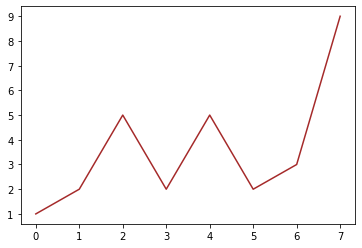

In [16]:
li_check=[1, 2, 5, 2, 5, 2,3, 9]
print(almost_increasing(li_check, 1))

plt.plot(li_check, color='brown')


In [46]:
# This function finds stable patients using some predefined rules 
def calculateStability(patient_id, trajectory):
    df_topic = pd.DataFrame()

#     print("displaying trajectory for patient {0}:".format(patient_id))
#     print("stages and associated vectors:")
 
    first = True 
    list_vec= []
    list_ang= []
    list_stages = []
    for stageID in trajectory:
        v = trajectory[stageID]
        # v_sorted=  sorted(list(set(v.tolist())))[-2]
      
#         print("\nstageID: {0}, vector: {1}, topic_max:{2} , and  {3}".format(stageID, v, v.argmax()+1,np.argsort(v,axis=0)[-2]+1)) 
        if len(trajectory)<=2:
          return
        list_vec.append(R)
        list_ang.append(theta)
        list_stages.append(v)

    print("\nResultant smooth ",np.round(smoothen(list_vec,len(list_vec), 3 if len(list_vec)>3 else len(list_vec)-1),4))

    print("-----------------------")
    print("Resultant ",np.round((list_vec),4))
    Orig_list_vec=list_vec
    list_vec=smoothen(list_vec,len(list_vec), 3 if len(list_vec)> 3 else len(list_vec)-1).tolist()
    # list_vec = [ round(elem, 2) for elem in list_vec ]
    # print("rounded  ",list_vec)
    print("-----------------------")
    gradient_r_values = np.gradient(list_vec)
    print("Gradients ",np.round(gradient_r_values,4))
    idxOfBestPoint = elbow_point(list_vec,gradient_r_values,Orig_list_vec)

    list0 = []
    list0.append([patient_id])
    # list0.append(list(value.values())[-1].tolist())
    # list0.append([list_vec[0]])
    # list0.append([list_vec[-1]])
    list0.append([v.argmax()+1])
    
       
    merged  = list(itertools.chain(*list0))
    # print(merged)

    df_topic= df_topic.append(pd.DataFrame([merged],columns=['patient_id','Max_topic']), ignore_index = True)
    flag,flag1 = "",None
    if (max(list_vec)-min(list_vec)>=1 and  strictly_increasing(list_vec[1:])) and all([val >= 0 for val in gradient_r_values])  : 
      print("\nThis patient is Stable \n \n 1 ")
      flag = "Stable"
    elif strictly_increasing(list_vec[:idxOfBestPoint] )and  strictly_increasing(list_vec[idxOfBestPoint:]) and list_vec.index( min(list_vec))<idxOfBestPoint and max(list_vec)-min(list_vec)>=1:
      print("\nThis patient is Stable  2 ")
      flag ="Stable"
    elif strictly_increasing(list_vec[:idxOfBestPoint]) and almost_increasing(list_vec[idxOfBestPoint:], 2) and( list_vec[-1]!= min(list_vec[idxOfBestPoint:])) and max(list_vec)-min(list_vec)>=1: 
      print("\nThis patient is Stable  3 ")
      flag ="Stable"
  
    elif almost_increasing(list_vec, 1)  and max(list_vec)-min(list_vec)>=1 and( list_vec.index( min(list_vec))==0 and max(list_vec)==list_vec[-1]):
      print("\nThis patient is Stable 4  ")
      flag ="Stable"

    elif  almost_increasing(list_vec[:idxOfBestPoint], 2) and strictly_increasing(list_vec[idxOfBestPoint:]) and idxOfBestPoint <= 1:
      print("\nThis patient is Stable 5  ")
      flag ="Stable"

    elif  max(list_vec)-min(list_vec)<1.:
      print("This patient is unstable")
      flag ='Unstable'

    elif ( max(list_vec)-min(list_vec)<1 and  all([val >= 0 for val in gradient_r_values[idxOfBestPoint:-1]])) and (not strictly_increasing( list_vec[idxOfBestPoint:-1])) :
      print("This patient is unstable")
      flag ='Unstable'

    elif not strictly_increasing(list_vec[:idxOfBestPoint]) and not strictly_increasing(list_vec[idxOfBestPoint:]) and almost_increasing(list_vec[:idxOfBestPoint], 2)  and idxOfBestPoint >= len(list_vec)/2 :
        print("\n This patient is  stable until  stage:*",idxOfBestPoint )
        
        flag,flag1 ="Until ", idxOfBestPoint

    elif strictly_increasing(list_vec[:idxOfBestPoint]) and not strictly_increasing(list_vec[idxOfBestPoint:]):
      print("\n This patient is  stable until  stage:",idxOfBestPoint )
      flag, flag1 ="Until ", idxOfBestPoint

    elif  strictly_increasing( list_vec[idxOfBestPoint:-1] ) and all([val >= 0 for val in gradient_r_values[idxOfBestPoint:-1]]) and list_vec.index( min(list_vec))== idxOfBestPoint:
      
        print("This patient is  stable from stag:",idxOfBestPoint)
        flag,flag1 ="From ", idxOfBestPoint


    elif strictly_increasing( list_vec[list_vec.index( min(list_vec)):-1]) and list_vec.index( min(list_vec))< idxOfBestPoint and not strictly_increasing(list_vec ):
        print("This patient is  stable from stage:",list_vec.index( min(list_vec)))
        flag,flag1 ="From ", idxOfBestPoint
 
    elif not strictly_increasing(list_vec[:idxOfBestPoint] )and  strictly_increasing(list_vec[idxOfBestPoint:]):
        print("This patient is  stable from stage:",idxOfBestPoint)
        flag,flag1 ="From ", idxOfBestPoint


    df_topic['Ground_truth']= flag
    df_topic['Stage']= flag1

    del merged
    del list0 

    return df_topic

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### illustrate stability on a random sample of patients

in the code below, we pick a random patient and 

- retrieve its sequence of stages (trajectory)
- calucalte the corresponding <R, theta> sequence, one for each stage in their timeline
- determine its stability

In [137]:
import numpy as np

def trendline(index,data, order=1):
    coeffs = np.polyfit(index, list(data), order)
    slope = coeffs[-2]
    return float(slope)


def calculateStabilityRecord(patient_id, min_timeline_length, printDiag=True):
    
    listOfConditions = stagesPerPatient[patient_id][-1]

    if printDiag:
        print("patient {} with conditions: \n{}".format(patient_id,listOfConditions ))
        
    patient_trajectory = trajectories[patient_id]

    # print each vector and the corresponding resultant and diff
    RSeq = []  ## sequence of R values
    ThetaSeq = []  ## sequence of theta values
    i = 0
    for stageID in patient_trajectory.keys():

        vector = patient_trajectory[stageID]
        if printDiag:
            print("stage {0}: vector: {1}".format(stageID,pprintAssocVector(vector) ))

        i += 1
        if i == len(patient_trajectory.keys()):
            lastVector = vector

        ## forces resultant
        R, theta = resultant(vector)

        RSeq.append(R)
        ThetaSeq.append(theta)

        if printDiag:
            if theta == 0:
                print("\t\tR = {0:.2f}, theta = {1}".format(R, theta))
            else:
                print("\t\tR = {0:.2f}, theta = {1:.2f}deg".format(R, theta))

    if len(RSeq) > min_timeline_length:
        trend = trendline(range(len(RSeq)),RSeq)
        stable = (trend > 0.1)
        dominantCluster = float("NaN")
        if stable:
            dominantCluster = np.argmax(lastVector)
        if printDiag:
            print("trend for R: {0:.2f}".format(trend))
            print("stable == {}".format(stable))
            print("dominant cluster: {}".format(dominantCluster))
                
        return {COLUMN_NAMES[0]: patient_id, COLUMN_NAMES[1]: listOfConditions, COLUMN_NAMES[2]: stable, COLUMN_NAMES[3]:trend, COLUMN_NAMES[4]: dominantCluster} 
    
    
    else:
        if printDiag:
            print("sequence too short for stability predictions")
        return None

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
COLUMN_NAMES = ['patientID','conditions','stable','trend','dominantCluster']


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [139]:
### calculate stability on a random sample of the entire population, and save the result into a new DF

import random

min_timeline_length = 2
all_patient_ids = trajectories.keys()

sample_size = 100


df_stability = pd.DataFrame(columns=COLUMN_NAMES) 

skipped = 0
for n in range(sample_size):
    i = random.randint(0,len(all_patient_ids))
    random_patient_id = list(all_patient_ids)[i]
    stabilityRecord = calculateStabilityRecord(random_patient_id, min_timeline_length, printDiag=False)
    
    if stabilityRecord == None:
        skipped += 1
        
    df_stability = df_stability.append(stabilityRecord, ignore_index = True)

print(" {} patients skipped due to short timelines".format(skipped)) 

df_stability

 23 patients skipped due to short timelines


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,patientID,conditions,stable,trend,dominantCluster
0,3272828,"[CHD, obesity, hypertension, allergic_rhinitis...",True,0.489004,1
1,2956433,"[anxiety_phobia, GORD, hypertension, CKD, obes...",False,-0.009883,NaN
2,2637379,"[female_genital_prolapse, PD, somatoform, cin_...",True,0.435252,2
3,3785199,"[urolithiasis, spondylosis, osteoporosis, hear...",True,0.512263,1
4,4003250,"[sinusitis, somatoform, hypertension, asthma, ...",True,0.304170,0
...,...,...,...,...,...
72,2366714,"[hearing_loss, meniere, hypertension, depressi...",True,0.136111,1
73,1106528,"[anxiety_phobia, depression, GORD, pri_bladder]",True,0.436686,2
74,2725155,"[hyposplenism, pri_coloretal_anus, alcohol_dep...",True,0.429555,1
75,1454470,"[cin_cervical, pri_cervical, enthesopathy]",True,0.256817,2
